<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aqui estruturamos todo o trabalho para a entrega do Tech Challenge 2.**

1. Depois de vários testes para saber quais bibliotecas seriam necessárias, trouxemos todas elas no início para manter a rastreabilidade.

In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from pandas.tseries.offsets import BDay




2. Importação e leitura do arquivo, que foi feito o upload no Github. Durante a preparação,fomos atualizando com versões mais atualizadas do arquivo até o momento da entrega.

In [492]:
# URL do arquivo bruto
url = 'https://raw.githubusercontent.com/laribar/TechChallenge2/refs/heads/main/Dados%20Historicos%20-%20Ibovespa.csv'

# Leia o CSV usando pandas, especificando decimal e thousands, e parse_dates para converter a data corretamente
df = pd.read_csv(url, decimal=',', thousands='.', parse_dates=['Data'], dayfirst=True)

# Exibir as primeiras linhas do DataFrame
print(df.head())

        Data  Último  Abertura  Máxima  Mínima    Vol.    Var%
0 2025-02-17  129058    128229  129306  128229   3,56M   0,65%
1 2025-02-14  128219    124849  128482  124849  12,56B   2,70%
2 2025-02-13  124850    124372  124853  123778   9,05B   0,38%
3 2025-02-12  124380    126513  126513  124116  14,63B  -1,69%
4 2025-02-11  126522    125571  126886  125570  11,24B   0,76%


3. Para facilitar o entendimento, trocamos o nome da coluna último por fechamento.

In [493]:
# Renomear a coluna 'último' para 'fechamento'
df.rename(columns={'Último': 'Fechamento'}, inplace=True)

# Visualizar as primeiras linhas após renomear as colunas
print("\nColunas após a renomeação:")
print(df.columns)

# Exibir as primeiras linhas do DataFrame para confirmar a alteração
print(df.head())


Colunas após a renomeação:
Index(['Data', 'Fechamento', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')
        Data  Fechamento  Abertura  Máxima  Mínima    Vol.    Var%
0 2025-02-17      129058    128229  129306  128229   3,56M   0,65%
1 2025-02-14      128219    124849  128482  124849  12,56B   2,70%
2 2025-02-13      124850    124372  124853  123778   9,05B   0,38%
3 2025-02-12      124380    126513  126513  124116  14,63B  -1,69%
4 2025-02-11      126522    125571  126886  125570  11,24B   0,76%


In [494]:
# Supondo que você já tenha carregado os dados e renomeado a coluna conforme necessário

# Converter a coluna 'Data' para o tipo datetime, caso ainda não esteja
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

# Verifique se houve alguma falha ao converter
if df['Data'].isnull().any():
    print("Atenção: Existem valores em 'Data' que não puderam ser convertidos. Verifique suas entradas de dados.")

# Definir 'Data' como índice
df.set_index('Data', inplace=True)

# Verifique as primeiras linhas para confirmar a mudança
print(df.head())

            Fechamento  Abertura  Máxima  Mínima    Vol.    Var%
Data                                                            
2025-02-17      129058    128229  129306  128229   3,56M   0,65%
2025-02-14      128219    124849  128482  124849  12,56B   2,70%
2025-02-13      124850    124372  124853  123778   9,05B   0,38%
2025-02-12      124380    126513  126513  124116  14,63B  -1,69%
2025-02-11      126522    125571  126886  125570  11,24B   0,76%


In [495]:
# Resumo estatístico dos dados
print(df.describe())

          Fechamento       Abertura         Máxima         Mínima
count    4948.000000    4948.000000    4948.000000    4948.000000
mean    72876.289410   72856.462207   73554.417745   72165.868432
std     29122.278716   29118.182685   29274.377387   28967.598989
min     23887.000000   23883.000000   24260.000000   23680.000000
25%     51895.000000   51867.000000   52491.000000   51376.250000
50%     63503.500000   63495.500000   64122.500000   62872.000000
75%    100558.000000  100553.250000  101560.750000   99634.250000
max    137344.000000  137349.000000  137469.000000  136664.000000


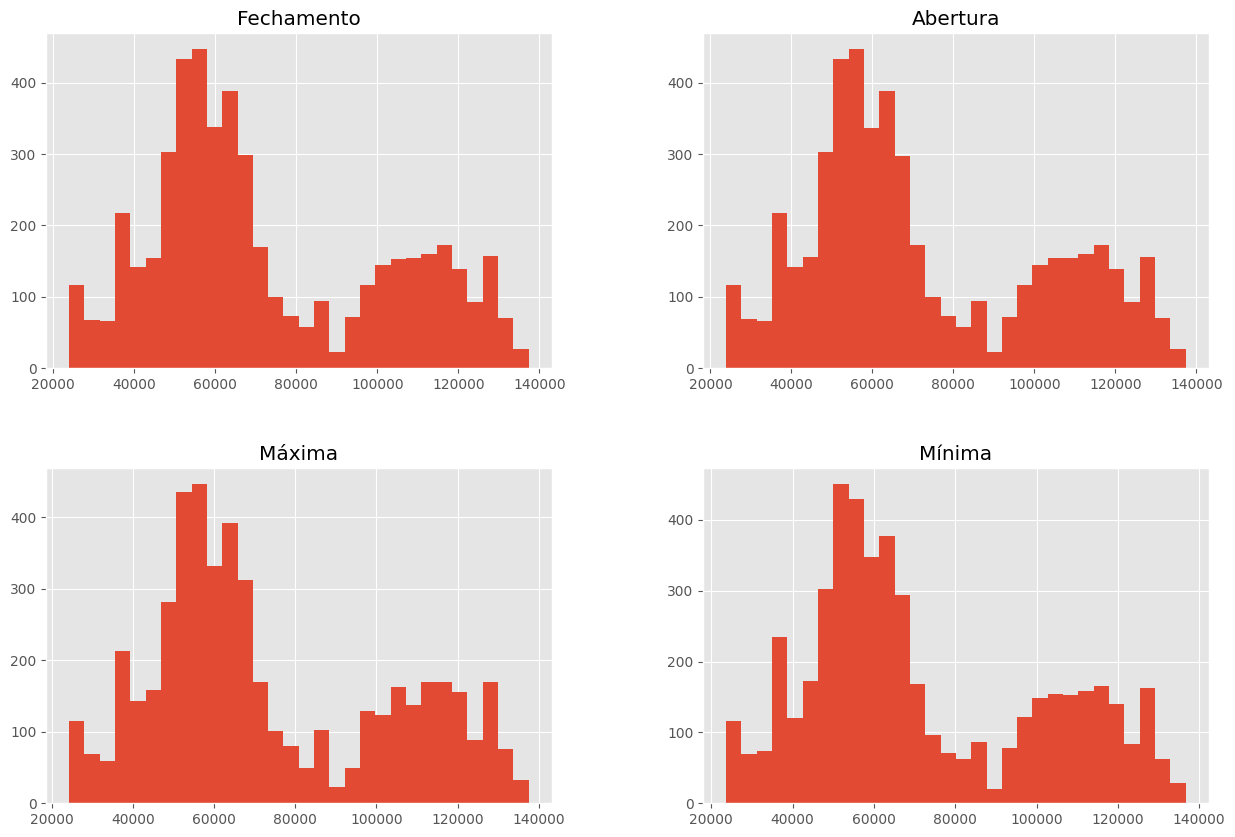

In [496]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4948 entries, 2025-02-17 to 2005-03-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Fechamento  4948 non-null   int64 
 1   Abertura    4948 non-null   int64 
 2   Máxima      4948 non-null   int64 
 3   Mínima      4948 non-null   int64 
 4   Vol.        4947 non-null   object
 5   Var%        4948 non-null   object
dtypes: int64(4), object(2)
memory usage: 270.6+ KB


In [498]:
# Mostra exemplos de valores que não puderam ser convertidos
problemas = df[df['Vol.'].isna()]['Vol.']
print(problemas.head(10))  # Exibir alguns valores problemáticos

Data
2016-02-10    NaN
Name: Vol., dtype: object


In [499]:
def percent_to_float(percent_str):
    try:
        return float(percent_str.replace(',', '.').replace('%', '')) / 100
    except ValueError:
        return None

# Suponha que a coluna 'Var%' contenha valores percentuais
df['Var%'] = df['Var%'].map(lambda x: percent_to_float(x) if isinstance(x, str) else x)

# Verifique as primeiras linhas para certificar-se da conversão adequada
print(df[['Var%']].head())

              Var%
Data              
2025-02-17  0.0065
2025-02-14  0.0270
2025-02-13  0.0038
2025-02-12 -0.0169
2025-02-11  0.0076


In [500]:
df.info(
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4948 entries, 2025-02-17 to 2005-03-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fechamento  4948 non-null   int64  
 1   Abertura    4948 non-null   int64  
 2   Máxima      4948 non-null   int64  
 3   Mínima      4948 non-null   int64  
 4   Vol.        4947 non-null   object 
 5   Var%        4948 non-null   float64
dtypes: float64(1), int64(4), object(1)
memory usage: 270.6+ KB


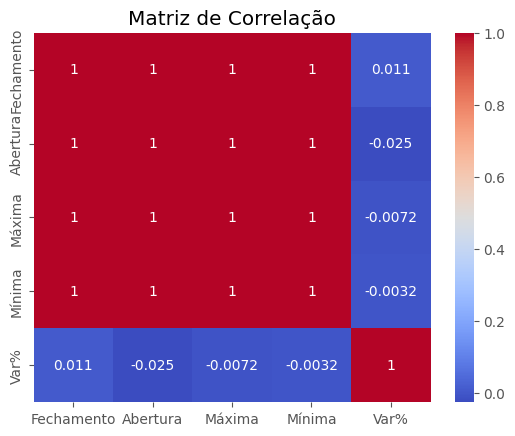

In [501]:
dfsemvol = df.drop(columns=['Vol.'])
correlation_matrix = dfsemvol.corr()

# Visualização gráfica
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [502]:
# Preencher ou remover valores ausentes
df.fillna(method='ffill', inplace=True)

<ipython-input-502-b3ecaff05721>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [503]:
# Confira a lista de colunas ou visualize o índice do DataFrame
print("Colunas do DataFrame:")
print(df.columns.tolist())

print("\nNome do Índice:")
print(df.index.name)

Colunas do DataFrame:
['Fechamento', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']

Nome do Índice:
Data


In [504]:
# Exemplo acessando valores diretamente baseados no índice
print(df.loc['2025-01-30'])  # Supondo um acesso específico

Fechamento    126913
Abertura      123433
Máxima        127169
Mínima        123432
Vol.          11,69B
Var%          0.0282
Name: 2025-01-30 00:00:00, dtype: object


In [505]:
# Variável alvo (dependente)
y = df['Fechamento']

# Variáveis preditoras (independentes) - adaptável conforme análise aprofundada
X = df.drop(columns=['Fechamento' ])  # Exclua colunas desnecessárias como 'Var%', por exemplo

# Dividir o conjunto de dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar conjuntos
print("Conjuntos de treino:", X_train.shape, y_train.shape)
print("Conjuntos de teste:", X_test.shape, y_test.shape)

Conjuntos de treino: (3958, 5) (3958,)
Conjuntos de teste: (990, 5) (990,)


In [506]:
# Ordenar os dados se necessário - geralmente por data é essencial para séries temporais
df.sort_index(inplace=True)

# Verificar o dataset
print(df.head())

            Fechamento  Abertura  Máxima  Mínima     Vol.    Var%
Data                                                             
2005-03-01       27730     28135   28137   27643  102,72M -0.0145
2005-03-02       28200     27730   28200   27498   82,65M  0.0169
2005-03-03       28668     28204   28766   28204  107,09M  0.0166
2005-03-04       29197     28676   29228   28676  228,27M  0.0185
2005-03-07       29455     29464   29584   29183  138,84M  0.0088


In [507]:
# Assegure-se de que a coluna 'Data' está no tipo datetime e é o índice
df.index = pd.to_datetime(df.index)

# Dividir o dataset em treino até 2025-01-25 e teste dos últimos 5 dias
cutoff_date = '2025-01-25'
train = df.loc[:cutoff_date].copy()
test = df.loc[cutoff_date:].copy()

print("Período de treino até:", train.index.max())
print("Período de testes a partir de:", test.index.min())

Período de treino até: 2025-01-24 00:00:00
Período de testes a partir de: 2025-01-27 00:00:00


In [508]:

# Use deslocamentos (lags) nos dados pode ser uma técnica adicional mesmo em modelos que não sejam tradicionais para séries da regressão.
train['Lag1'] = train['Fechamento'].shift(1)

# Remover valores nulos iniciais
train.dropna(inplace=True)

# Aplicar o modelo para ajuste no conjunto de treino
X_train = train[['Lag1']]  # Exemplo simples de uma variável de atraso
y_train = train['Fechamento']

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [509]:
# Corrigir coluna Lag1 no conjunto de teste para dados semelhantes a treino
test['Lag1'] = test['Fechamento'].shift(1)

# Atualizar dados removendo NaN provenientes de deslocamento
X_test = test[['Lag1']].dropna()
y_test = test.loc[X_test.index, 'Fechamento']  # Garantir mesmo índice de X_test

In [510]:
# Assegure-se de que a coluna 'Data' está no tipo datetime e é o índice
df.index = pd.to_datetime(df.index)

# Dividir o dataset em treino até 2025-01-25 e teste dos últimos 5 dias
cutoff_date = '2025-01-25'
train = df.loc[:cutoff_date].copy()
test = df.loc[cutoff_date:].copy()

print("Período de treino até:", train.index.max())
print("Período de testes a partir de:", test.index.min())

Período de treino até: 2025-01-24 00:00:00
Período de testes a partir de: 2025-01-27 00:00:00


In [511]:
# Use deslocamento para seuo ámbito de treinamento
train['Lag1'] = train['Fechamento'].shift(1)
train.dropna(inplace=True)  # Remova quaisquer `NaN` que resultam do deslocamento

In [512]:
# Defina as variáveis preditoras e alvo
X_train = train[['Lag1']]
y_train = train['Fechamento']

# Criação do modelo e ajuste
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [513]:
# Preparar dados de teste considerando como tentativa predictor nos hábitos da mesma
test['Lag1'] = test['Fechamento'].shift(1)
X_test = test[['Lag1']].dropna()  # Eliminando qualquer linha subsequente a falha de valor ocorrido

# Colocar previsões
y_pred = modelo.predict(X_test)
test.loc[X_test.index, 'Previsoes'] = y_pred

print("Previsões ajustadas para últimos 5 dias:")
print(test[['Fechamento', 'Previsoes']])

Previsões ajustadas para últimos 5 dias:
            Fechamento      Previsoes
Data                                 
2025-01-27      124862            NaN
2025-01-28      124056  124844.421501
2025-01-29      123432  124038.989871
2025-01-30      126913  123415.429900
2025-01-31      126135  126893.975189
2025-02-03      125970  126116.523814
2025-02-04      125147  125951.640168
2025-02-05      125534  125129.220526
2025-02-06      126225  125515.947624
2025-02-07      124619  126206.460349
2025-02-10      125572  124601.592858
2025-02-11      126522  125553.920828
2025-02-12      124380  126503.250912
2025-02-13      124850  124362.761395
2025-02-14      128219  124832.429963
2025-02-17      129058  128199.054232


In [514]:
# Verifique quais linhas têm valores NaN na coluna 'Fechamento'
print(test[['Fechamento', 'Previsoes']].isna().sum())

# Remova quaisquer linhas nas quais 'Previsoes' ou 'Fechamento' contenham 'NaN'
test_dropna = test.dropna(subset=['Fechamento', 'Previsoes'])

# Calcule novamente as métricas usando apenas linhas válidas
mae = mean_absolute_error(test_dropna['Fechamento'], test_dropna['Previsoes'])
mse = mean_squared_error(test_dropna['Fechamento'], test_dropna['Previsoes'])
rmse = np.sqrt(mse)  # Requer numpy
r2 = r2_score(test_dropna['Fechamento'], test_dropna['Previsoes'])

# Exiba os resultados
print(f"Erro Médio Absoluto (MAE): {mae:.2f}")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

Fechamento    0
Previsoes     1
dtype: int64
Erro Médio Absoluto (MAE): 1206.59
Erro Quadrático Médio (MSE): 2432382.66
Raiz do Erro Quadrático Médio (RMSE): 1559.61
Coeficiente de Determinação (R²): -0.14


In [515]:
# Exemplo genérico de criação de features
# Ajuste conforme a estrutura dos seus dados
df['Lag1'] = df['Fechamento'].shift(1)
df.dropna(inplace=True)  # Remove NaN após a aplicação do shift

# Supondo apenas Lag1 para simplificação, mas você deve adicionar mais se necessárias
features = df[['Lag1']]
target = df['Fechamento']

In [516]:

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [517]:


# Instanciar modelo Random Forest
rf = RandomForestRegressor(random_state=42)

# Ajustar o modelo com dados de treino
rf.fit(X_train, y_train)

# Prever com conjunto de teste
rf_predictions = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse:.2f}")

Random Forest RMSE: 1303.01


In [518]:


# Calcule métricas mais detalhadas
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

# Exiba as métricas calculadas
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest MAE: 965.05
Random Forest MSE: 1697823.07
Random Forest RMSE: 1303.01
Random Forest R²: 1.00


In [519]:
# Instanciar o modelo Random Forest treinado anteriormente
rf = RandomForestRegressor(random_state=42)

# Caminho correto considerando que rf foi usado anteriormente:
rf.fit(X_train, y_train)

# Então vamos com previsões para novos dados
best_rf = rf  # Use rf diretamente se best_rf não estiver definido

In [520]:
import pandas as pd

# Supondo você quer prever os próximos 5 dias baseados na última observação
last_observation = df['Fechamento'].iloc[-1]
future_dates = pd.date_range(start=df.index[-1], periods=6, freq='D')[1:]  # Define os próximos 5 dias

# Considerando 'Lag1' usada como exemplo ou ajuste conforme suas features
future_features = pd.DataFrame({'Lag1': [last_observation] * len(future_dates)}, index=future_dates)

future_predictions = rf.predict(future_features)

# Exibir as previsões futuras
print("Previsões para os próximos 5 dias:")
for date, prediction in zip(future_dates, future_predictions):
    print(f"{date.date()}: {prediction:.2f}")

Previsões para os próximos 5 dias:
2025-02-18: 129824.21
2025-02-19: 129824.21
2025-02-20: 129824.21
2025-02-21: 129824.21
2025-02-22: 129824.21


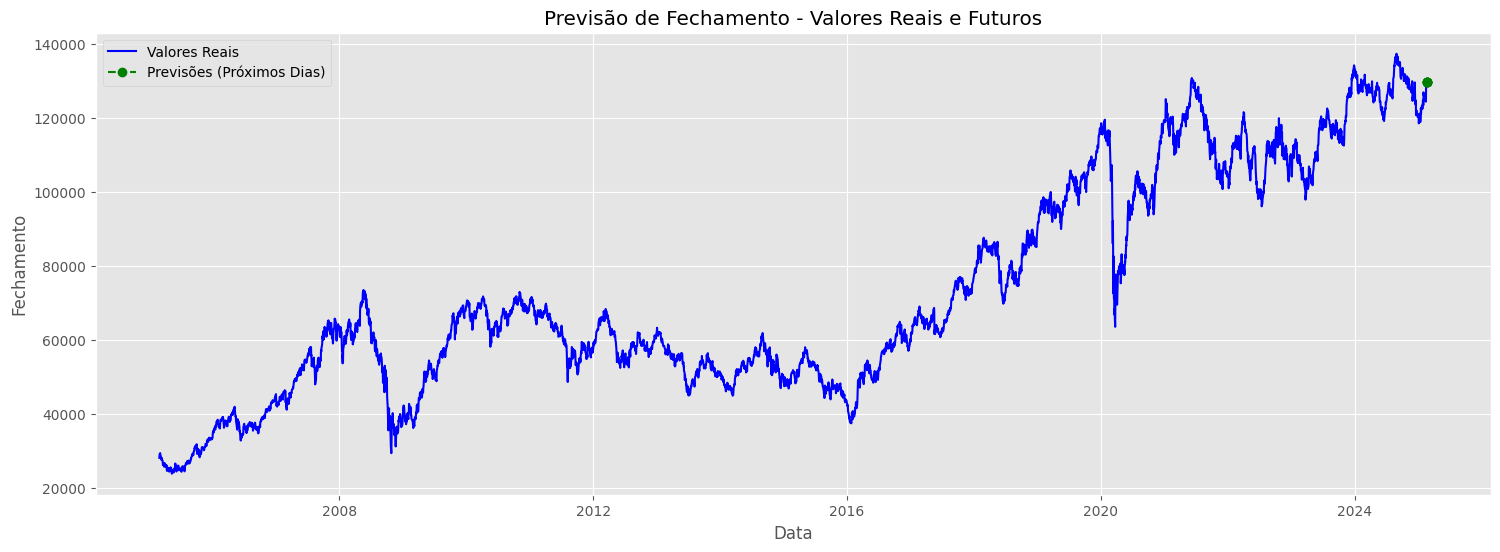

In [521]:
# Configuração do gráfico
plt.figure(figsize=(18, 6))

# Plot valores reais
plt.plot(df.index, df['Fechamento'], label='Valores Reais', color='blue')

# Adicione previsões para os próximos dias
plt.plot(future_dates, future_predictions, label='Previsões (Próximos Dias)', color='green', linestyle='--', marker='o')

# Configurações do gráfico
plt.title('Previsão de Fechamento - Valores Reais e Futuros')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)

# Exiba o gráfico
plt.show()

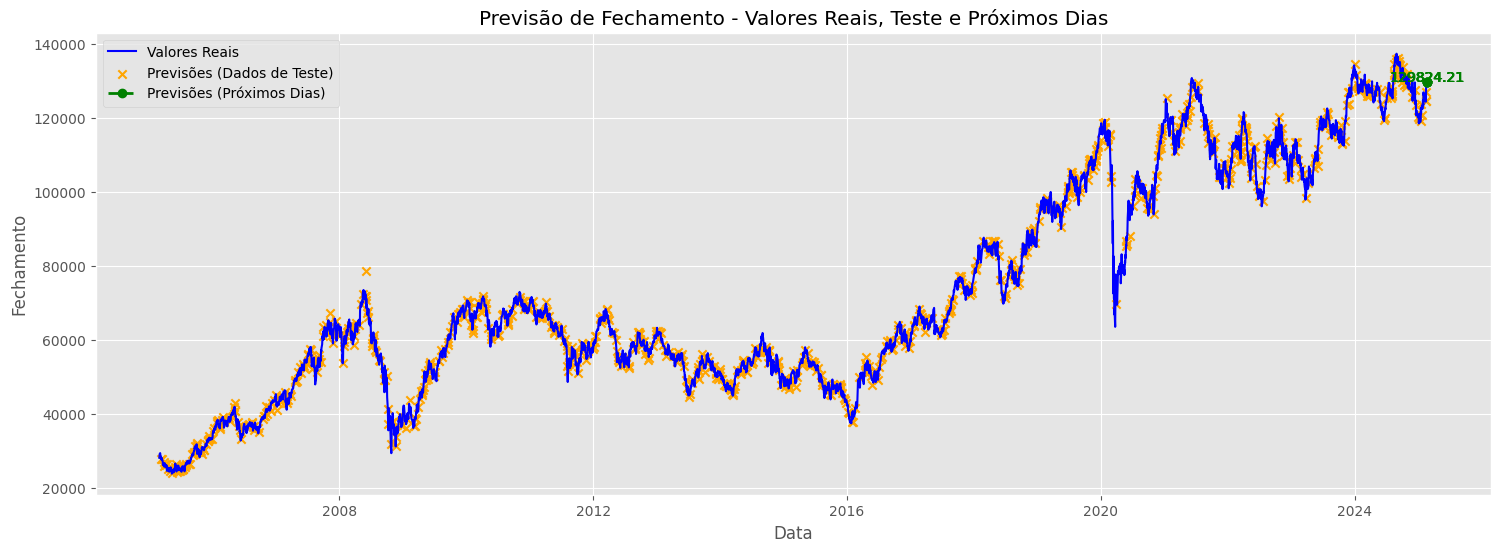

In [522]:

# Configuração do gráfico
plt.figure(figsize=(18, 6))

# Plotar os valores reais
plt.plot(df.index, df['Fechamento'], label='Valores Reais', color='blue')

# Plotar as previsões do conjunto de teste
plt.scatter(y_test.index, rf_predictions, label='Previsões (Dados de Teste)', color='orange', marker='x')

# Plotar as previsões futuras
plt.plot(future_dates, future_predictions, label='Previsões (Próximos Dias)', color='green', linestyle='--', marker='o', linewidth=2)

# Adicionar rótulos acima das bolinhas de previsão futura
for date, prediction in zip(future_dates, future_predictions):
    plt.text(date, prediction + 2,  # desloca +2 para cima no eixo Y
             f'{prediction:.2f}',  # formatação com 2 casas decimais
             color='green', fontsize=10, ha='center')

# Configuração do gráfico
plt.title('Previsão de Fechamento - Valores Reais, Teste e Próximos Dias')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()


In [523]:
# Adicionado mais lags e recursos derivados
df['Lag1'] = df['Fechamento'].shift(1)
df['Lag2'] = df['Fechamento'].shift(2)
df['Lag3'] = df['Fechamento'].shift(3)
df['Lag4'] = df['Fechamento'].shift(4)
df['Lag5'] = df['Fechamento'].shift(5)
df['Daily_Return'] = df['Fechamento'].pct_change()
df.dropna(inplace=True)

# Features para treino
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Daily_Return']]
y = df['Fechamento']

# Re-treino do modelo
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [524]:
df['Lag3'] = df['Fechamento'].shift(3)# Simulação com variabilidade baseada em histórico
future_predictions_adjusted = []
print("Previsões ajustadas:")
for pred in future_predictions:
    variation = np.random.uniform(-0.5, 0.5)  # Adiciona variação de até +/- 0.5
    adjusted_pred = pred + variation  # Adapta o valor com variação simulada
    future_predictions_adjusted.append(adjusted_pred)

for date, prediction in zip(future_dates, future_predictions_adjusted):
    print(f"{date.date()}: {prediction:.2f}")

Previsões ajustadas:
2025-02-18: 129824.43
2025-02-19: 129824.20
2025-02-20: 129824.45
2025-02-21: 129824.29
2025-02-22: 129824.38


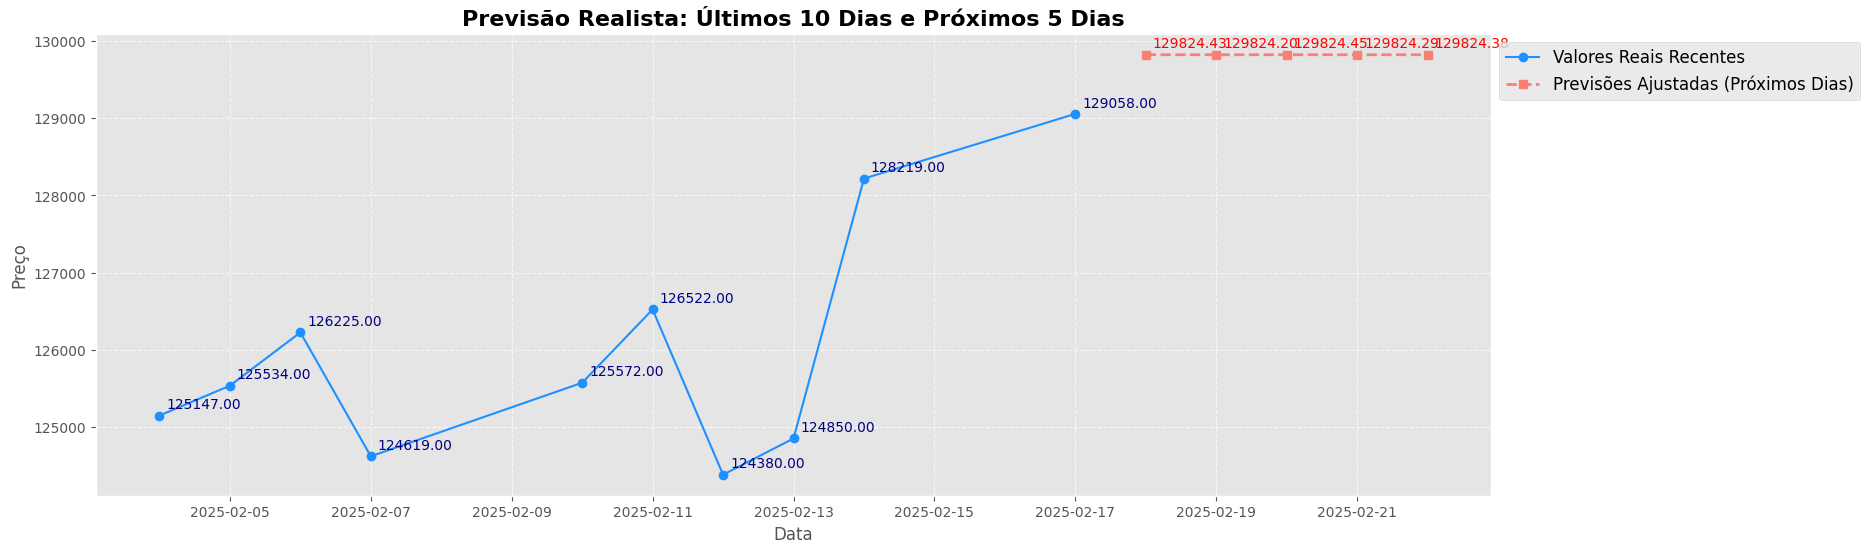

In [525]:
plt.style.use('ggplot')

plt.figure(figsize=(18, 6))
plt.plot(df.index[-10:], df['Fechamento'][-10:], label='Valores Reais Recentes', color='dodgerblue', marker='o')
plt.plot(future_features.index, future_predictions_adjusted,
         label='Previsões Ajustadas (Próximos Dias)', color='salmon', linestyle='--', marker='s', linewidth=2)

# Adicionar rótulos aos valores reais
for date, value in zip(df.index[-10:], df['Fechamento'][-10:]):
    plt.annotate(f'{value:.2f}', xy=(date, value), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='navy')

# Adicionar rótulos às previsões futuras
for date, prediction in zip(future_features.index, future_predictions_adjusted):
    plt.annotate(f'{prediction:.2f}', xy=(date, prediction), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='red')

plt.title('Previsão Realista: Últimos 10 Dias e Próximos 5 Dias', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

In [526]:
# Calcule métricas mais detalhadas
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

# Exiba as métricas calculadas
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest MAE: 965.05
Random Forest MSE: 1697823.07
Random Forest RMSE: 1303.01
Random Forest R²: 1.00


In [527]:
# 🔹 2️⃣ Feature Engineering
df['Lag1'] = df['Fechamento'].shift(1)
df['Lag2'] = df['Fechamento'].shift(2)
df['Lag3'] = df['Fechamento'].shift(3)
df['Lag4'] = df['Fechamento'].shift(4)
df['Lag5'] = df['Fechamento'].shift(5)
df['Daily_Return'] = df['Fechamento'].pct_change()

# 🔹 Médias móveis
df['SMA10'] = df['Fechamento'].rolling(window=10).mean()
df['SMA20'] = df['Fechamento'].rolling(window=20).mean()
df['SMA50'] = df['Fechamento'].rolling(window=50).mean()

# 🔹 Volatilidade e estatísticas recentes
df['Volatility5'] = df['Fechamento'].rolling(window=5).std()
df['Max5'] = df['Fechamento'].rolling(window=5).max()
df['Min5'] = df['Fechamento'].rolling(window=5).min()

# 🔹 Bandas de Bollinger (usadas para medir volatilidade)
df['BB_upper'] = df['SMA20'] + (df['Fechamento'].rolling(window=20).std() * 2)
df['BB_lower'] = df['SMA20'] - (df['Fechamento'].rolling(window=20).std() * 2)

# 🔹 Índice de Força Relativa (RSI)
delta = df['Fechamento'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# 🔹 MACD (Média Móvel Convergência/Divergência)
df['MACD'] = df['Fechamento'].ewm(span=12, adjust=False).mean() - df['Fechamento'].ewm(span=26, adjust=False).mean()


In [528]:
# Prever o fechamento do próximo dia
df['Target'] = df['Fechamento'].shift(-1)  # Move os valores de fechamento para cima (previsão do futuro)
df.dropna(inplace=True)  # Remove linhas com NaN geradas pelo shift

# 🔹 4️⃣ Separar treino e teste (80% treino, 20% teste, sem embaralhar)
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Daily_Return', 'SMA10', 'SMA20', 'SMA50',
        'Volatility5', 'Max5', 'Min5', 'BB_upper', 'BB_lower', 'RSI', 'MACD']]
y = df['Target']


# Treinar o modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [529]:
# Calcule métricas mais detalhadas
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

# Exiba as métricas calculadas
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest MAE: 965.05
Random Forest MSE: 1697823.07
Random Forest RMSE: 1303.01
Random Forest R²: 1.00


In [530]:
# Criar datas dos próximos 5 dias úteis
future_dates = [df.index[-1] + BDay(i) for i in range(1, 6)]

# Preparar features para previsão futura
future_features = df.iloc[-5:][['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Daily_Return',
 'SMA10', 'SMA20', 'SMA50', 'Volatility5', 'Max5', 'Min5',
 'BB_upper', 'BB_lower', 'RSI', 'MACD']
]
future_features.index = future_dates  # Ajustar índice para as datas futuras
future_predictions = rf.predict(future_features)

# Ajustar previsões adicionando variação simulada
future_predictions_adjusted = []
for pred in future_predictions:
    variation = np.random.normal(scale=0.3 * np.std(df['Daily_Return']))  # Menor variação
    adjusted_pred = pred * (1 + variation)
    future_predictions_adjusted.append(adjusted_pred)

<ipython-input-531-623aee96458a>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


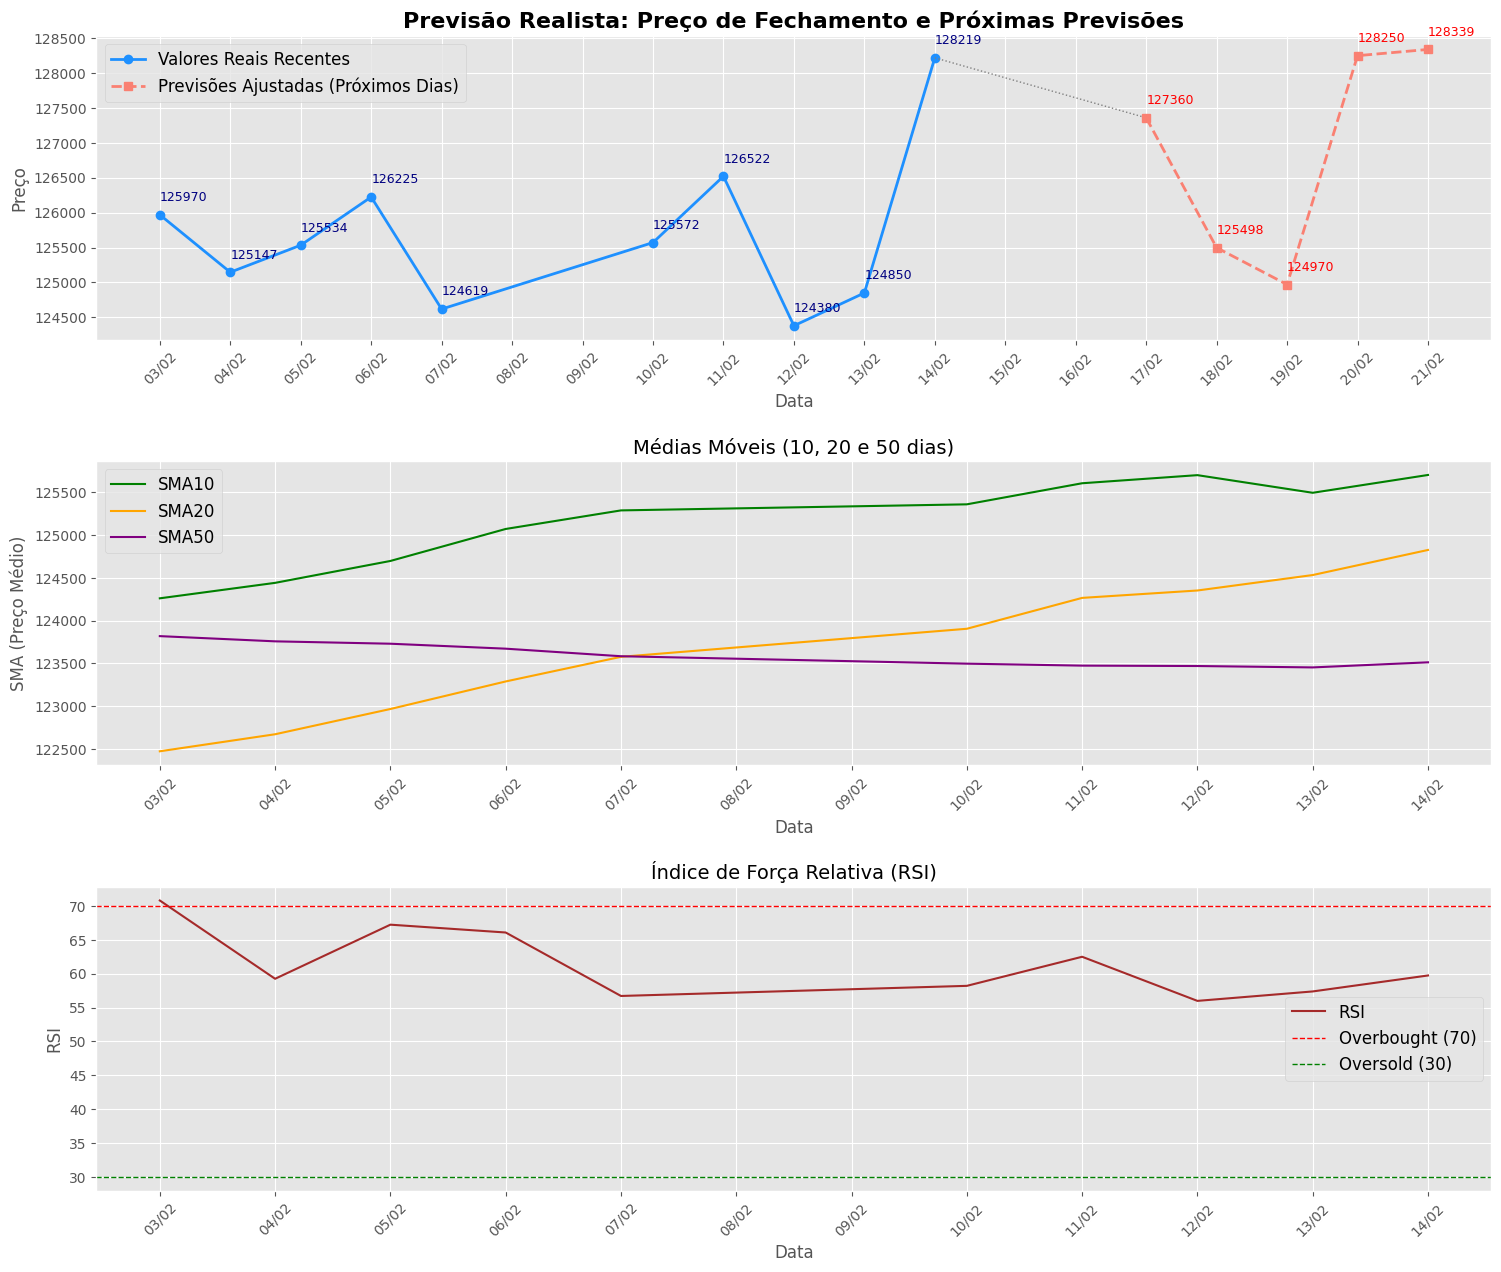

In [531]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Convertendo os índices para o formato datetime
df.index = pd.to_datetime(df.index)
future_features.index = pd.to_datetime(future_features.index)

# Configurando o estilo
plt.style.use('ggplot')

# Criando subgráficos: Principal (Fechamento e Previsões) e Indicadores
fig, axes = plt.subplots(3, 1, figsize=(18, 15), gridspec_kw={'hspace': 0.4})

# Gráfico Principal: Fechamento e Previsões
ax1 = axes[0]
ax1.plot(df.index[-10:], df['Fechamento'][-10:], label='Valores Reais Recentes', color='dodgerblue', marker='o', linewidth=2)
ax1.plot([df.index[-1], future_features.index[0]],
         [df['Fechamento'].iloc[-1], future_predictions_adjusted[0]], color='gray', linestyle='dotted', linewidth=1)
ax1.plot(future_features.index, future_predictions_adjusted, label='Previsões Ajustadas (Próximos Dias)',
         color='salmon', linestyle='--', marker='s', linewidth=2)

# Formatação do eixo X
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Configuração para marcar cada dia
ax1.tick_params(axis='x', rotation=45)

# Rótulos e anotações no gráfico principal
for date, value in zip(df.index[-10:], df['Fechamento'][-10:]):
    ax1.annotate(f'{value:.0f}', xy=(date, value), xytext=(0, 10), textcoords='offset points', fontsize=9, color='navy')
for date, prediction in zip(future_features.index, future_predictions_adjusted):
    ax1.annotate(f'{prediction:.0f}', xy=(date, prediction), xytext=(0, 10), textcoords='offset points', fontsize=9, color='red')

# Configurações do Gráfico Principal
ax1.set_title('Previsão Realista: Preço de Fechamento e Próximas Previsões', fontsize=16, fontweight='bold')
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Preço', fontsize=12)
ax1.legend(fontsize=12)

# Gráfico 2: Médias Móveis (SMA10, SMA20, SMA50)
ax2 = axes[1]
ax2.plot(df.index[-10:], df['SMA10'][-10:], label='SMA10', color='green', linewidth=1.5)
ax2.plot(df.index[-10:], df['SMA20'][-10:], label='SMA20', color='orange', linewidth=1.5)
ax2.plot(df.index[-10:], df['SMA50'][-10:], label='SMA50', color='purple', linewidth=1.5)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.tick_params(axis='x', rotation=45)

ax2.set_title('Médias Móveis (10, 20 e 50 dias)', fontsize=14)
ax2.set_xlabel('Data', fontsize=12)
ax2.set_ylabel('SMA (Preço Médio)', fontsize=12)
ax2.legend(fontsize=12)

# Gráfico 3: RSI com linhas de referência (70 e 30)
ax3 = axes[2]
ax3.plot(df.index[-10:], df['RSI'][-10:], label='RSI', color='brown', linestyle='-', linewidth=1.5)
ax3.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
ax3.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax3.tick_params(axis='x', rotation=45)

ax3.set_title('Índice de Força Relativa (RSI)', fontsize=14)
ax3.set_xlabel('Data', fontsize=12)
ax3.set_ylabel('RSI', fontsize=12)
ax3.legend(fontsize=12)

# Ajustando espaçamentos e mostrando o gráfico
plt.tight_layout()
plt.show()


In [532]:
# Calcule métricas mais detalhadas
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

# Exiba as métricas calculadas
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest MAE: 965.05
Random Forest MSE: 1697823.07
Random Forest RMSE: 1303.01
Random Forest R²: 1.00
